# Applications of ML for Networking Final Project
---
#### Name: 劉耀文 (Yao-Wen Liu)
#### Student ID: 311551045
---

## Data Input and library import

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib

import warnings
warnings.filterwarnings("ignore")

column_name = ['NSS', 'MCS', 'GI', 'throughput', 'airtime_per', 'other_per']
dataset = pd.read_csv('network_trace.txt', sep=" ", names=column_name, header=None)
dataset

,NSS,MCS,GI,throughput,airtime_per,other_per
0,2,6,1,51.055077,0.075920,0.0
1,2,7,1,50.742508,0.093920,0.0
2,1,9,1,51.897148,0.093228,0.0
3,2,8,1,49.850716,0.095052,0.0
4,2,5,1,51.727776,0.100688,0.0
...,...,...,...,...,...,...
367,1,9,0,51.375793,0.136256,0.0
368,2,5,0,49.931450,0.107029,0.0
369,2,4,0,50.180573,0.124320,0.0
370,2,5,0,49.762260,0.108120,0.0


## Data Preprocessing
* Most of the preprocessing is done in the publisher.py / subscriber.py.
* The label is from the next second's throughput
    * If throughput >= 60 Mbps, then quality = 0 (1080p)
    * 60 > tp >= 40, quality = 1 (900p)
    * 40 > tp >= 30, quality = 2 (720p)
    * 30 > tp >= 20, quality = 3 (540p)
    * 20 > tp      , quality = 4 (360p)

In [9]:
label = []
for i in range(1, len(dataset)):
    if(dataset.at[i, 'throughput'] >= 50):
        label.append(0)
    elif(dataset.at[i, 'throughput'] >= 40):
        label.append(1)
    elif(dataset.at[i, 'throughput'] >= 30):
        label.append(2)
    elif(dataset.at[i, 'throughput'] >= 20):
        label.append(3)
    else:
        label.append(4)
label.append(0)
dataset['label'] = label
dataset
print(label)

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 2, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 2, 3, 1, 1, 1, 3, 2, 2, 2, 1, 1, 1, 2, 2, 1, 3, 3, 3, 2, 4, 4, 2, 4, 4, 4, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 4, 3, 4, 4, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 4, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 3, 2, 2, 0, 1, 0, 1, 0, 1, 1, 1, 2, 3, 4, 3, 4, 4, 4, 4, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 3, 4, 3, 3, 3, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 4, 4, 2, 1, 1, 3, 4, 3, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 3, 2, 

In [10]:
# drop first row because the label is not correct
dataset = dataset.drop(dataset.index[-1], axis=0)

# drop the throughput column, which is replaced by the quality
dataset = dataset.drop(['throughput'], axis=1)

# Shuffle the data.
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset

,NSS,MCS,GI,airtime_per,other_per,label
0,2,5,0,0.107816,0.000000,2
1,2,4,0,0.117132,0.572644,2
2,2,2,1,0.158744,0.565519,3
3,1,8,0,0.118508,0.562503,1
4,1,1,1,0.106320,0.510424,4
...,...,...,...,...,...,...
366,2,1,1,0.148260,0.374320,3
367,2,2,1,0.193480,0.000000,2
368,2,3,1,0.169512,0.468384,2
369,1,5,1,0.202956,0.176700,1


## Data Visualization

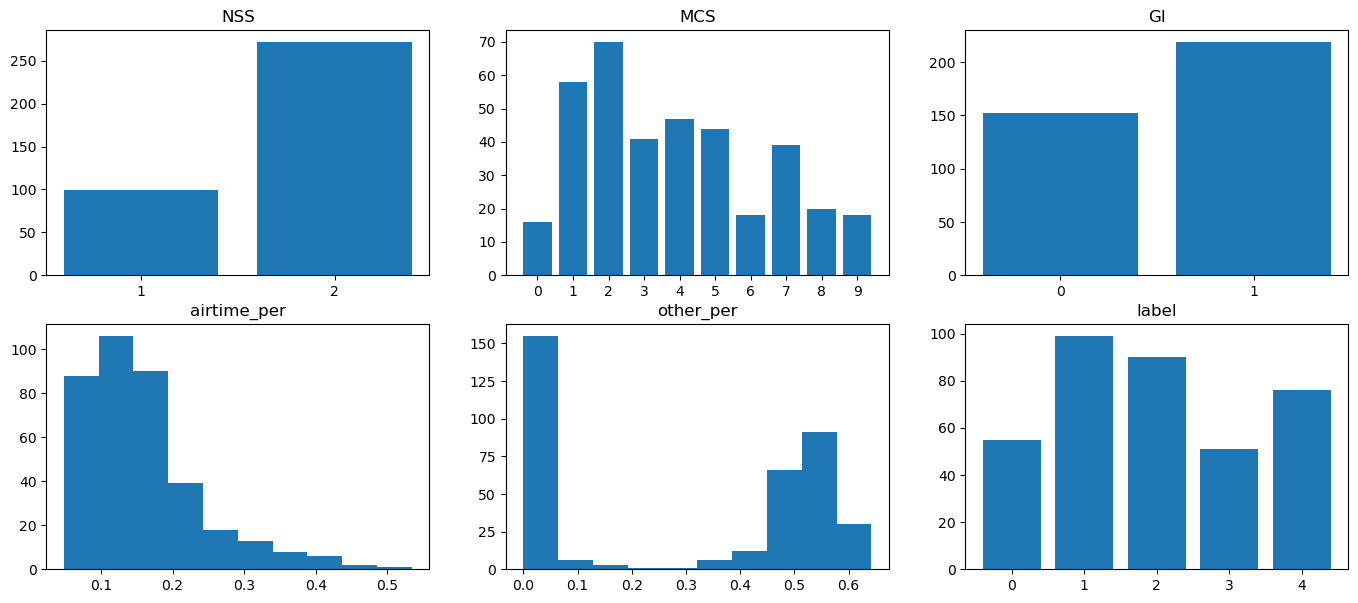

In [11]:
index = 0
plt.figure(figsize=(16.8, 7))
for feature in dataset:
    plt.subplot(2, 3, index + 1)
    # numeric features
    if feature == 'airtime_per' or feature == 'other_per':
        plt.hist(dataset[feature], bins=10, range=[dataset[feature].min(), dataset[feature].max()])
        plt.title(feature)
    # symbolic features
    else:
        tmp_col = dataset[feature].astype(str)
        labels, i=np.unique(tmp_col, return_index=True)
        counts=[]
        for j in range(0,len(labels)):
            counts.append(tmp_col.tolist().count(labels[j]))
        plt.bar(labels, counts)
        plt.title(feature)
    index += 1
plt.savefig('data_visualization.png', bbox_inches='tight')

## Model Construction and Performance
#### Decision Tree

iteration #1 Recall: [0.66666667 0.37037037 0.47222222 0.42105263 0.70833333]
iteration #1 Precision: [0.54545455 0.38461538 0.5483871  0.44444444 0.62962963]
iteration #1 F1-Score: [0.6        0.37735849 0.50746269 0.43243243 0.66666667]



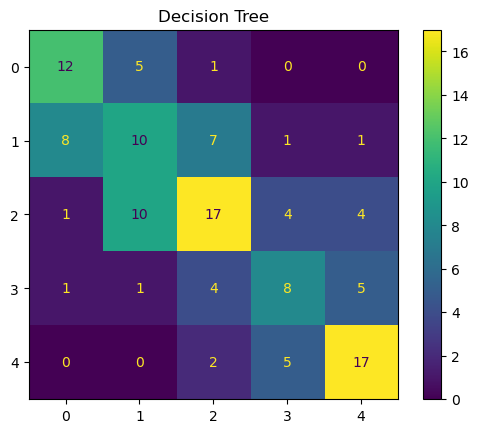

iteration #2 Recall: [0.29411765 0.34285714 0.28571429 0.16666667 0.25      ]
iteration #2 Precision: [0.3125     0.4137931  0.26666667 0.07142857 0.38095238]
iteration #2 F1-Score: [0.3030303  0.375      0.27586207 0.1        0.30188679]



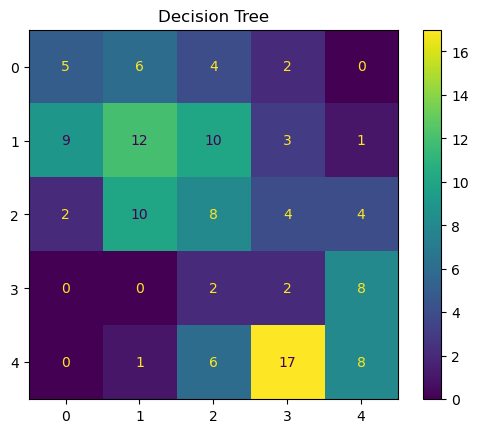

iteration #3 Recall: [0.5        0.37837838 0.46153846 0.2        0.45      ]
iteration #3 Precision: [0.43478261 0.46666667 0.3        0.25       0.64285714]
iteration #3 F1-Score: [0.46511628 0.41791045 0.36363636 0.22222222 0.52941176]



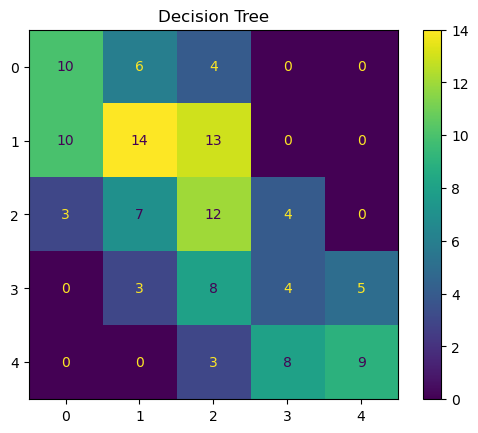

In [12]:
y_train = dataset['label']
X_train = dataset.drop(['label'], axis=1)

k_fold = KFold(n_splits=3)
k_fold.get_n_splits(X_train)

iteration = 1
clf = DecisionTreeClassifier(criterion="entropy")
for train_index, validation_index in k_fold.split(X_train):
    x_train_cv, x_validation_cv = X_train.values[train_index], X_train.values[validation_index]
    y_train_cv, y_validation_cv = y_train[train_index], y_train[validation_index]
    
    clf.fit(x_train_cv, y_train_cv)
    y_predict_cv = clf.predict(x_validation_cv)
    
    print(f'iteration #{iteration} Recall: {recall_score(y_validation_cv, y_predict_cv, average=None)}')
    print(f'iteration #{iteration} Precision: {precision_score(y_validation_cv, y_predict_cv, average=None)}')
    print(f'iteration #{iteration} F1-Score: {f1_score(y_validation_cv, y_predict_cv, average=None)}')
    print()
    
    conf_matrix = confusion_matrix(y_true=y_validation_cv, y_pred=y_predict_cv)
    titles = ['Decision Tree']
    f, axes = plt.subplots()

    for i in range(0,1):
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
        disp.plot(ax=axes)
        disp.ax_.set_title(titles[i])
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        disp.ax_.set_ylabel('')

    f.colorbar(disp.im_, ax=axes)
    plt.savefig(f'confusion_matrix{iteration}.png', bbox_inches='tight')
    plt.show()
    iteration += 1

#### Performance

Recall: [0.81818 0.76768 0.84444 0.68627 0.85526]
Precision: [0.77586 0.82609 0.73077 0.74468 0.92857]
F1-Score: [0.79646 0.79581 0.78351 0.71429 0.89041]
Average: 0.79437, 0.80119, 0.79609


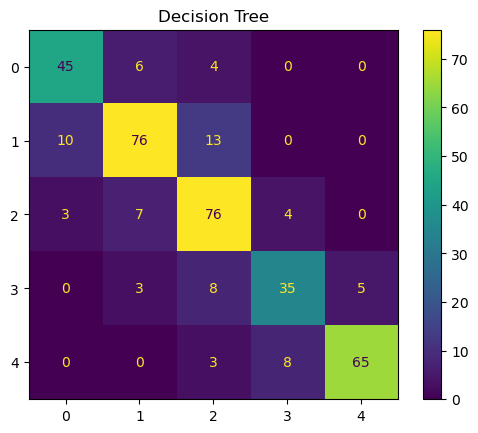

In [13]:
y_pred = clf.predict(X_train)

conf_matrix = confusion_matrix(y_true=y_train, y_pred=y_pred)

recall = recall_score(y_train, y_pred, average=None)
precision = precision_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average=None)

print(f'Recall: {np.round(recall, 5)}')
print(f'Precision: {np.round(precision, 5)}')
print(f'F1-Score: {np.round(f1, 5)}')
print(f'Average: {np.round(np.average(recall), 5)}, {np.round(np.average(precision), 5)}, {np.round(np.average(f1), 5)}')

titles = ['Decision Tree']
f, axes = plt.subplots()

for i in range(0,1):
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
    disp.plot(ax=axes)
    disp.ax_.set_title(titles[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

## Modeling Saving
* Save the ML model as file to be imported by the adaptation module.

In [14]:
joblib.dump(clf, 'pre-trained_model')

['pre-trained_model']